In [ ]:
#@title 2nd model (jupyter)

In [ ]:
# Install necessary libraries
!pip install tensorflow matplotlib numpy -q --user

# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Libraries installed and imported successfully!")


Libraries installed and imported successfully!


In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Split into Train, Validation, and Test Sets

# Define dataset directory
dataset_dir = "D:\\NOOR 4TH YEAR\\OCTDL after augmentation"
assert os.path.exists(dataset_dir), "Dataset directory not found!"

# Get all class directories (subdirectories inside the dataset)
class_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# Create directories for train, validation, and test sets
train_dir = "D:\\NOOR 4TH YEAR\\split\\train"
val_dir = "D:\\NOOR 4TH YEAR\\split\\val"
test_dir = "D:\\NOOR 4TH YEAR\\split\\test"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Helper function to split data
def split_data(class_dirs, dataset_dir, train_dir, val_dir, test_dir, train_size=0.8, val_size=0.1):
    for class_dir in class_dirs:
        # Path to current class directory
        class_path = os.path.join(dataset_dir, class_dir)

        # List all images in the current class directory
        all_images = [os.path.join(class_path, f) for f in os.listdir(class_path)]

        # Split images into train, validation, and test sets
        train_images, temp_images = train_test_split(all_images, train_size=train_size, random_state=42)
        val_images, test_images = train_test_split(temp_images, train_size=val_size / (1 - train_size), random_state=42)

        # Create class subdirectories in train, val, and test directories
        os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)

        # Move images to respective directories
        for image in train_images:
            shutil.copy(image, os.path.join(train_dir, class_dir))
        for image in val_images:
            shutil.copy(image, os.path.join(val_dir, class_dir))
        for image in test_images:
            shutil.copy(image, os.path.join(test_dir, class_dir))

# Split the data
split_data(class_dirs, dataset_dir, train_dir, val_dir, test_dir)

# Display the number of images in each split
train_images_count = sum([len(files) for r, d, files in os.walk(train_dir)])
val_images_count = sum([len(files) for r, d, files in os.walk(val_dir)])
test_images_count = sum([len(files) for r, d, files in os.walk(test_dir)])

print(f"Training Set contains {train_images_count} images.")
print(f"Validation Set contains {val_images_count} images.")
print(f"Test Set contains {test_images_count} images.")


Training Set contains 14859 images.
Validation Set contains 1857 images.
Test Set contains 1860 images.


In [ ]:
# Load and Prepare Data Generators

# ImageDataGenerator for rescaling pixel values (train, validation, and test sets)
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to between 0 and 1
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator= train_datagen.flow_from_directory(
    train_dir,  # Path to training directory
    target_size=(224, 224),  # Resize all images to 224x224 (VGG16 input size)
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

# Validation generator
val_generator= val_datagen.flow_from_directory(
    val_dir,  # Path to validation directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Test generator
test_generator= test_datagen.flow_from_directory(
    test_dir,  # Path to test directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Don't shuffle test set for evaluation purposes
)


Found 14859 images belonging to 7 classes.
Found 1857 images belonging to 7 classes.
Found 1860 images belonging to 7 classes.


In [ ]:
#  Build the VGG16 Model

# Load VGG16 pre-trained on ImageNet without the top layer (no classification head)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16 so that they are not trained during the initial phase
base_model.trainable = False

# Build the complete model by adding custom layers on top of VGG16
model = models.Sequential([
    base_model,  # Add the pre-trained VGG16 model as the base
    layers.Flatten(),  # Flatten the output of the convolutional base to feed into dense layers
    layers.Dense(512, activation='relu'),  # Fully connected layer with ReLU activation
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(7, activation='softmax')  # Final softmax layer for multi-class classification (7 classes)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the Model with Learning Rate Scheduler

history = model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Steps per epoch
    epochs=10,  # Number of epochs
    validation_data=val_generator,  # Validation data generator
    validation_steps=val_generator.samples // val_generator.batch_size,  # Validation steps
    callbacks=[reduce_lr]  # Include the learning rate scheduler callback
)


Epoch 1/10
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x0000021999FEF600>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x0000021999FEF600>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. O

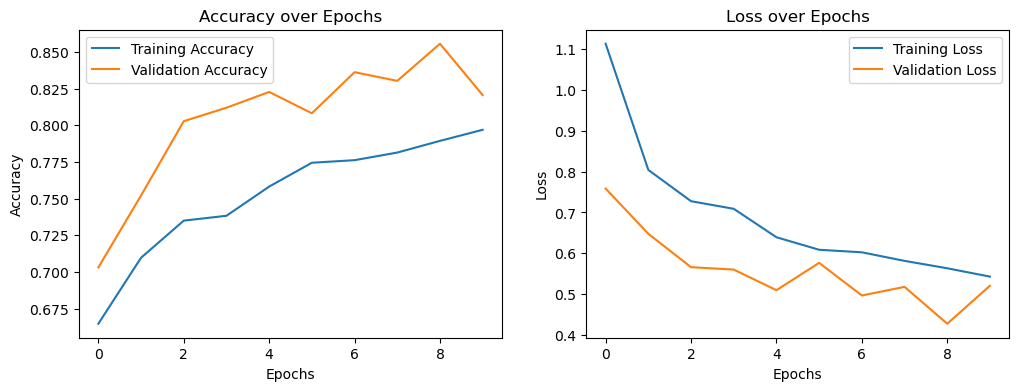

In [ ]:
# Visualize Training and Validation Accuracy & Loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# @title Step 8 : Evaluate the Model on Test Set

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


58/58 [==============================] - 150s 3s/step - loss: 0.4882 - accuracy: 0.8303
Test Loss: 0.48824912309646606
Test Accuracy: 0.8302801847457886


In [ ]:
#@title 1st model

In [ ]:
# Install necessary libraries (if not already installed)
!pip install tensorflow matplotlib numpy -q

# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Libraries installed and imported successfully!")


Libraries installed and imported successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

#Data Split into Train, Validation, and Test Sets

# Define dataset directory
dataset_dir = "/content/drive/MyDrive/graduation project/OCTDL"  # Replace with your dataset path
assert os.path.exists(dataset_dir), "Dataset directory not found!"

# Get all class directories (subdirectories inside the dataset)
class_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# Create directories for train, validation, and test sets
train_dir = "/content/drive/MyDrive/graduation project/octdl,split/train  "
val_dir = "/content/drive/MyDrive/graduation project/octdl,split/val"
test_dir = "/content/drive/MyDrive/graduation project/octdl,split/test"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Helper function to split data
def split_data(class_dirs, dataset_dir, train_dir, val_dir, test_dir, train_size=0.8, val_size=0.1):
    for class_dir in class_dirs:
        # Path to current class directory
        class_path = os.path.join(dataset_dir, class_dir)

        # List all images in the current class directory
        all_images = [os.path.join(class_path, f) for f in os.listdir(class_path)]

        # Split images into train, validation, and test sets
        train_images, temp_images = train_test_split(all_images, train_size=train_size, random_state=42)
        val_images, test_images = train_test_split(temp_images, train_size=val_size / (1 - train_size), random_state=42)

        # Create class subdirectories in train, val, and test directories
        os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)

        # Move images to respective directories
        for image in train_images:
            shutil.copy(image, os.path.join(train_dir, class_dir))
        for image in val_images:
            shutil.copy(image, os.path.join(val_dir, class_dir))
        for image in test_images:
            shutil.copy(image, os.path.join(test_dir, class_dir))

# Split the data
split_data(class_dirs, dataset_dir, train_dir, val_dir, test_dir)

# Display the number of images in each split
train_images_count = sum([len(files) for r, d, files in os.walk(train_dir)])
val_images_count = sum([len(files) for r, d, files in os.walk(val_dir)])
test_images_count = sum([len(files) for r, d, files in os.walk(test_dir)])

print(f"Training Set contains {train_images_count} images.")
print(f"Validation Set contains {val_images_count} images.")
print(f"Test Set contains {test_images_count} images.")


Training Set contains 1647 images.
Validation Set contains 206 images.
Test Set contains 211 images.


In [ ]:
# Load and Prepare Data Generators

# ImageDataGenerator for rescaling pixel values (train, validation, and test sets)
train_datagen= ImageDataGenerator(rescale=1./255)  # Normalize pixel values to between 0 and 1
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to training directory
    target_size=(224, 224),  # Resize all images to 224x224 (VGG16 input size)
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    val_dir,  # Path to validation directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Path to test directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Don't shuffle test set for evaluation purposes
)


Found 1647 images belonging to 7 classes.
Found 206 images belonging to 7 classes.
Found 211 images belonging to 7 classes.


In [ ]:
# Build the VGG16 Model

# Load VGG16 pre-trained on ImageNet without the top layer (no classification head)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16 so that they are not trained during the initial phase
base_model.trainable = False

# Build the complete model by adding custom layers on top of VGG16
model = models.Sequential([
    base_model,  # Add the pre-trained VGG16 model as the base
    layers.Flatten(),  # Flatten the output of the convolutional base to feed into dense layers
    layers.Dense(512, activation='relu'),  # Fully connected layer with ReLU activation
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(7, activation='softmax')  # Final softmax layer for multi-class classification (7 classes)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the Model with Learning Rate Scheduler

history = model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Steps per epoch
    epochs=10,  # Number of epochs
    validation_data=val_generator,  # Validation data generator
    validation_steps=val_generator.samples // val_generator.batch_size,  # Validation steps
    callbacks=[reduce_lr]  # Include the learning rate scheduler callback
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1019s 20s/step - accuracy: 0.5059 - loss: 3.0479 - val_accuracy: 0.6875 - val_loss: 0.8192 - learning_rate: 0.0010
Epoch 2/10
 1/51 ━━━━━━━━━━━━━━━━━━━━ 14:18 17s/step - accuracy: 0.7188 - loss: 0.7772

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.7188 - loss: 0.7772 - val_accuracy: 0.6823 - val_loss: 0.8299 - learning_rate: 0.0010
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1039s 20s/step - accuracy: 0.7258 - loss: 0.7804 - val_accuracy: 0.7083 - val_loss: 0.7589 - learning_rate: 0.0010
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.7500 - loss: 0.9145 - val_accuracy: 0.7135 - val_loss: 0.7302 - learning_rate: 0.0010
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1036s 20s/step - accuracy: 0.7900 - loss: 0.5926 - val_accuracy: 0.7917 - val_loss: 0.6076 - learning_rate: 0.0010
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.7812 - loss: 0.4839 - val_accuracy: 0.7760 - val_loss: 0.6031 - learning_rate: 0.0010
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1043s 20s/step - accuracy: 0.8069 - loss: 0.5273 - val_accuracy: 0.8073 - val_loss: 0.5820 - learning_rate: 0.0010
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8438 - loss: 0.4679 - val_accuracy

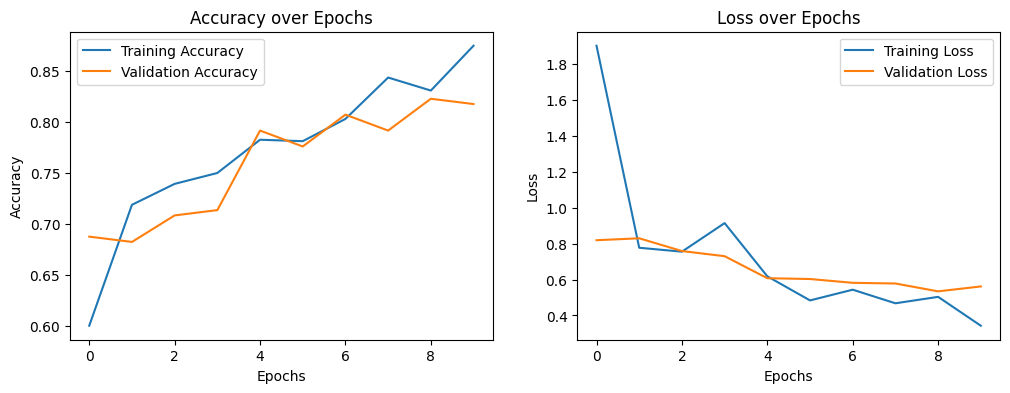

In [ ]:
# Visualize Training and Validation Accuracy & Loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 115s 16s/step - accuracy: 0.8914 - loss: 0.3215
✅ Final Test Accuracy: 0.8104
7/7 ━━━━━━━━━━━━━━━━━━━━ 114s 16s/step

📊 Classification Report:
               precision    recall  f1-score   support

         AMD       0.90      0.96      0.93       124
         DME       0.60      0.40      0.48        15
         ERM       0.50      0.62      0.56        16
          NO       0.72      0.97      0.82        34
         RAO       0.00      0.00      0.00         3
         RVO       1.00      0.09      0.17        11
         VID       1.00      0.25      0.40         8

    accuracy                           0.81       211
   macro avg       0.67      0.47      0.48       211
weighted avg       0.82      0.81      0.78       211



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


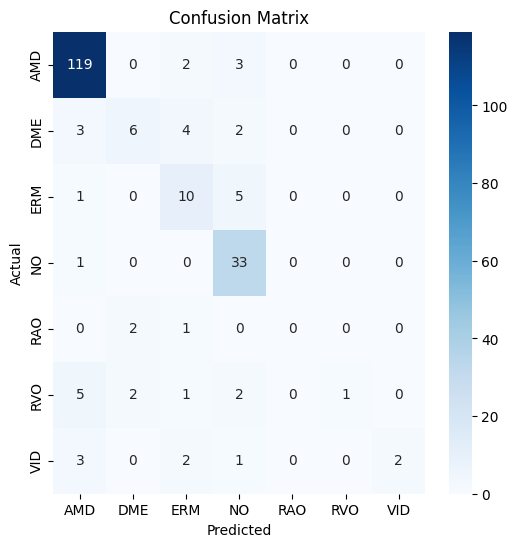


🔍 **Performance Metrics:**
✅ Classification Accuracy: 0.8104
📌 Sensitivity (Recall): 0.4709
📌 Specificity: 0.9579
📌 Precision: 0.6741
📌 False Positive Rate (FPR): 0.0421
📌 False Negative Rate (FNR): 0.5291
📌 Negative Predictive Value (NPV): 0.9663
📌 F1 Score: 0.4796


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

# ✅ Final Evaluation on Test Set
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")

# Get Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 📊 Classification Report
print("\n📊 Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

# 📌 Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 🎯 Calculate Performance Metrics
TP = np.diag(conf_matrix)  # True Positives
FP = np.sum(conf_matrix, axis=0) - TP  # False Positives
FN = np.sum(conf_matrix, axis=1) - TP  # False Negatives
TN = np.sum(conf_matrix) - (TP + FP + FN)  # True Negatives

# 🔹 Classification Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# 🔹 Sensitivity (Recall)
sensitivity = recall_score(y_true, y_pred_classes, average='macro')

# 🔹 Specificity
specificity = np.mean(TN / (TN + FP))

# 🔹 Precision
precision = precision_score(y_true, y_pred_classes, average='macro')

# 🔹 False Positive Rate (FPR)
fpr = np.mean(FP / (FP + TN))

# 🔹 False Negative Rate (FNR)
fnr = np.mean(FN / (TP + FN))

# 🔹 Negative Predictive Value (NPV)
npv = np.mean(TN / (TN + FN))

# 🔹 F1 Score
f1 = f1_score(y_true, y_pred_classes, average='macro')

# 📝 Print Metrics
print(f"\n🔍 **Performance Metrics:**")
print(f"✅ Classification Accuracy: {accuracy:.4f}")
print(f"📌 Sensitivity (Recall): {sensitivity:.4f}")
print(f"📌 Specificity: {specificity:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 False Positive Rate (FPR): {fpr:.4f}")
print(f"📌 False Negative Rate (FNR): {fnr:.4f}")
print(f"📌 Negative Predictive Value (NPV): {npv:.4f}")
print(f"📌 F1 Score: {f1:.4f}")

In [ ]:
#@title 3rd model

In [ ]:
import os
import cv2
import numpy as np
import random
import shutil
from tqdm import tqdm
from skimage import exposure
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define Paths
dataset_path = "/content/drive/MyDrive/graduation project/OCTDL"  # Update with your dataset path
output_path = "/content/drive/MyDrive/graduation project/OCT"
augmented_path = os.path.join(output_path, "/content/drive/MyDrive/graduation project/OCT")
split_path = os.path.join(output_path, "/content/drive/MyDrive/graduation project/OCT ,split")

In [ ]:
# Define classes
include_classes = ["AMD", "DME", "ERM", "NO", "RVO"]  # Keep only these classes
augment_classes = ["DME", "ERM", "RVO"]  # Apply augmentations
no_aug_classes = ["AMD"]  # No augmentation
no_special_aug_classes = ["NO"]  # Only histogram, blur, and sharpen
exclude_classes = ["RAO", "VID"]  # Exclude these classes


In [ ]:
# Create Augmented Data Folder
os.makedirs(augmented_path, exist_ok=True)


In [ ]:
# Augmentation Functions
def mirror(img):
    return cv2.flip(img, 1)

def rotate(img, angle=15):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, matrix, (w, h))

def histogram_equalization(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def blur(img, ksize=(5,5)):
    return cv2.GaussianBlur(img, ksize, 0)

def sharpen(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

In [ ]:

# Apply Augmentations and Save
print("🔄 Applying Augmentations...")

for cls in include_classes:
    class_path = os.path.join(dataset_path, cls)
    save_path = os.path.join(augmented_path, cls)
    os.makedirs(save_path, exist_ok=True)

    images = os.listdir(class_path)

    for img_name in tqdm(images, desc=f"Processing {cls}"):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"⚠️ Warning: Skipping {img_name} (Failed to Load)")
            continue

        # Save original image
        cv2.imwrite(os.path.join(save_path, img_name), img)

        # Apply augmentations based on class
        if cls in augment_classes:
            # Path 1: Mirror → Rotate → Histogram, Blur, Sharpen
            mirrored = mirror(img)
            rotated_mirrored = rotate(mirrored)
            cv2.imwrite(os.path.join(save_path, f"mirrored_{img_name}"), mirrored)
            cv2.imwrite(os.path.join(save_path, f"rotated_mirrored_{img_name}"), rotated_mirrored)

            # Path 2: Rotate → Histogram, Blur, Sharpen
            rotated = rotate(img)
            cv2.imwrite(os.path.join(save_path, f"rotated_{img_name}"), rotated)

            # Apply Histogram, Blur, Sharpen to rotated image
            for aug in [histogram_equalization, blur, sharpen]:
                aug_img = aug(rotated)
                aug_name = aug.__name__ + "_" + img_name
                cv2.imwrite(os.path.join(save_path, aug_name), aug_img)

        elif cls in no_special_aug_classes:
            # NO: Mirror → Rotate → Sharpen only
            mirrored = mirror(img)
            rotated_mirrored = rotate(mirrored)
            sharpened = sharpen(rotated_mirrored)
            cv2.imwrite(os.path.join(save_path, f"mirrored_{img_name}"), mirrored)
            cv2.imwrite(os.path.join(save_path, f"rotated_mirrored_{img_name}"), rotated_mirrored)
            cv2.imwrite(os.path.join(save_path, f"sharpened_{img_name}"), sharpened)

print("✅ Augmentation Completed")

🔄 Applying Augmentations...


Processing RVO: 100%|██████████| 101/101 [00:23<00:00,  4.24it/s]

✅ Augmentation Completed


In [ ]:
import os
import cv2
import numpy as np
import random
import shutil
from tqdm import tqdm
from google.colab import drive

# Create Train, Validation, Test Folders
for split in ["train", "val", "test"]:
    for cls in include_classes:
        os.makedirs(os.path.join(split_path, split, cls), exist_ok=True)

# Split Data into Train (70%), Validation (15%), Test (15%)
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

print("\n🔄 Splitting Augmented Dataset...")

for cls in include_classes:
    class_path = os.path.join(augmented_path, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    train_end = int(len(images) * train_ratio)
    val_end = train_end + int(len(images) * val_ratio)

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    # Move images to respective folders
    for img_name in train_imgs:
        shutil.move(os.path.join(class_path, img_name), os.path.join(split_path, "train", cls, img_name))

    for img_name in val_imgs:
        shutil.move(os.path.join(class_path, img_name), os.path.join(split_path, "val", cls, img_name))

    for img_name in test_imgs:
        shutil.move(os.path.join(class_path, img_name), os.path.join(split_path, "test", cls, img_name))

    # Log split details
    print(f"\n✅ {cls} Split Summary:")
    print(f"   📂 Train: {len(train_imgs)} images")
    print(f"   📂 Validation: {len(val_imgs)} images")
    print(f"   📂 Test: {len(test_imgs)} images")

print("\n🎯 Dataset Split Completed ✅")



🔄 Splitting Augmented Dataset...

✅ AMD Split Summary:
   📂 Train: 861 images
   📂 Validation: 184 images
   📂 Test: 186 images

✅ DME Split Summary:
   📂 Train: 720 images
   📂 Validation: 154 images
   📂 Test: 155 images

✅ ERM Split Summary:
   📂 Train: 759 images
   📂 Validation: 162 images
   📂 Test: 164 images

✅ NO Split Summary:
   📂 Train: 929 images
   📂 Validation: 199 images
   📂 Test: 200 images

✅ RVO Split Summary:
   📂 Train: 494 images
   📂 Validation: 106 images
   📂 Test: 107 images

🎯 Dataset Split Completed ✅


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Paths to dataset directories
train_dir = "/content/drive/MyDrive/graduation project/OCT ,split/train"
val_dir = "/content/drive/MyDrive/graduation project/OCT ,split/val"
test_dir = "/content/drive/MyDrive/graduation project/OCT ,split/test"


In [ ]:
# Image properties
IMG_SIZE = (224, 224)  # VGG16 input size
BATCH_SIZE = 32

In [ ]:
# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

Found 3765 images belonging to 5 classes.
Found 806 images belonging to 5 classes.
Found 814 images belonging to 5 classes.


In [ ]:
# Load Pretrained VGG16 Model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# Add custom classification layers
x = Flatten()(base_model.output)  # Flatten the output of the base model
x = Dense(512, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.5)(x)  # Add dropout for regularization
output = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Output layer

In [ ]:
# Build Model
model = Model(inputs=base_model.input, outputs=output)  # Use the output tensor, not the layer


In [ ]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train Model with Validation Data
history = model.fit(
    train_generator,
    validation_data=val_generator,  # Using validation set during training
    epochs=10,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 2198s 19s/step - accuracy: 0.5045 - loss: 1.2653 - val_accuracy: 0.7543 - val_loss: 0.6864
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 315ms/step - accuracy: 0.7639 - loss: 0.6678 - val_accuracy: 0.8176 - val_loss: 0.5230
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 38s 319ms/step - accuracy: 0.8254 - loss: 0.5033 - val_accuracy: 0.8350 - val_loss: 0.4666
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 39s 331ms/step - accuracy: 0.8494 - loss: 0.4154 - val_accuracy: 0.8300 - val_loss: 0.4596
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 42s 357ms/step - accuracy: 0.8686 - loss: 0.3686 - val_accuracy: 0.8672 - val_loss: 0.3917
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 339ms/step - accuracy: 0.8986 - loss: 0.3020 - val_accuracy: 0.8598 - val_loss: 0.4161
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 39s 330ms/step - accuracy: 0.9092 - loss: 0.2633 - val_accuracy: 0.8685 - val_loss: 0.3628
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 38s 321ms/step - accuracy: 0.9227 - loss: 0

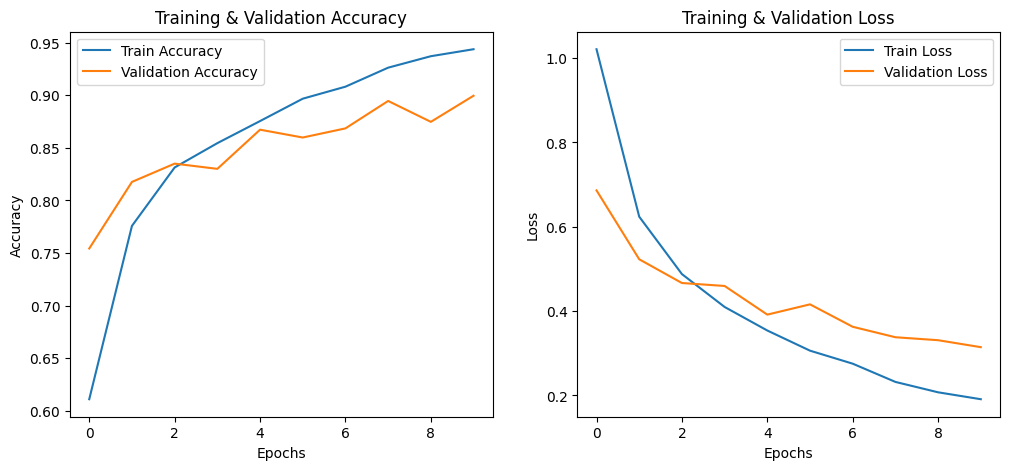

In [ ]:
# Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()


26/26 ━━━━━━━━━━━━━━━━━━━━ 408s 16s/step - accuracy: 0.8994 - loss: 0.2810
✅ Final Test Accuracy: 0.8980
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step

📊 Classification Report:
               precision    recall  f1-score   support

         AMD       0.93      0.93      0.93       188
         DME       0.91      0.83      0.87       155
         ERM       0.96      0.85      0.90       164
          NO       0.88      0.97      0.92       200
         RVO       0.80      0.89      0.84       107

    accuracy                           0.90       814
   macro avg       0.89      0.89      0.89       814
weighted avg       0.90      0.90      0.90       814



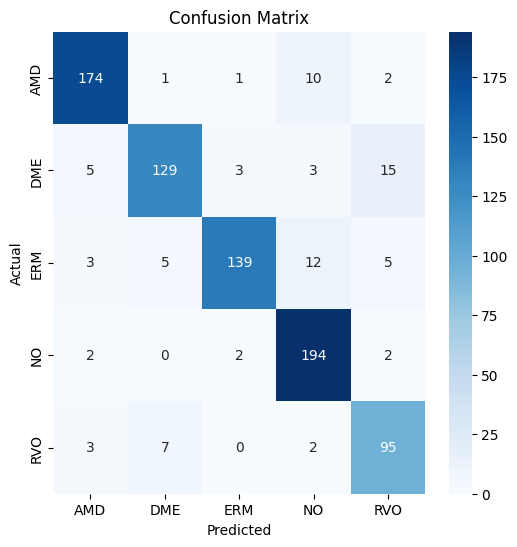

In [ ]:
# Final Evaluation on Test Set
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")

# Get Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\n📊 Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save('/content/model.h5')


In [ ]:
#@title 4th  model

In [ ]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train Model with Validation Data
history = model.fit(
    train_generator,
    validation_data=val_generator,  # Using validation set during training
    epochs=20,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1387s 12s/step - accuracy: 0.4971 - loss: 1.2719 - val_accuracy: 0.7667 - val_loss: 0.6444
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 315ms/step - accuracy: 0.7548 - loss: 0.6410 - val_accuracy: 0.7841 - val_loss: 0.5851
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - accuracy: 0.8312 - loss: 0.4781 - val_accuracy: 0.8449 - val_loss: 0.4489
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 342ms/step - accuracy: 0.8521 - loss: 0.4115 - val_accuracy: 0.8610 - val_loss: 0.4093
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 316ms/step - accuracy: 0.8806 - loss: 0.3369 - val_accuracy: 0.8734 - val_loss: 0.3626
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 313ms/step - accuracy: 0.9082 - loss: 0.2888 - val_accuracy: 0.8486 - val_loss: 0.4029
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 38s 322ms/step - accuracy: 0.9162 - loss: 0.2618 - val_accuracy: 0.8573 - val_loss: 0.3636
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 37s 312ms/step - accuracy: 0.9300 - loss: 0

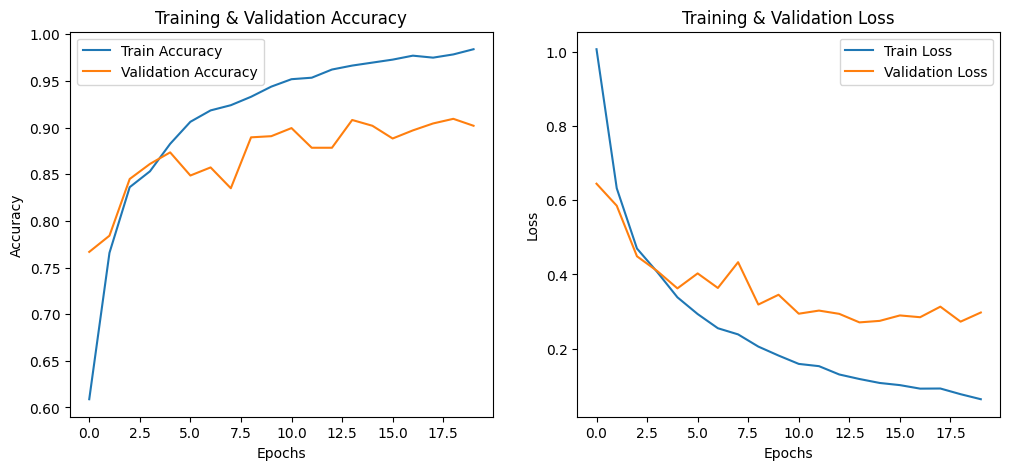

In [ ]:
# Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()


26/26 ━━━━━━━━━━━━━━━━━━━━ 286s 11s/step - accuracy: 0.9155 - loss: 0.2554
✅ Final Test Accuracy: 0.9103
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step

📊 Classification Report:
               precision    recall  f1-score   support

         AMD       0.96      0.91      0.93       188
         DME       0.86      0.90      0.88       155
         ERM       0.92      0.93      0.93       164
          NO       0.89      0.97      0.93       200
         RVO       0.93      0.79      0.85       107

    accuracy                           0.91       814
   macro avg       0.91      0.90      0.90       814
weighted avg       0.91      0.91      0.91       814



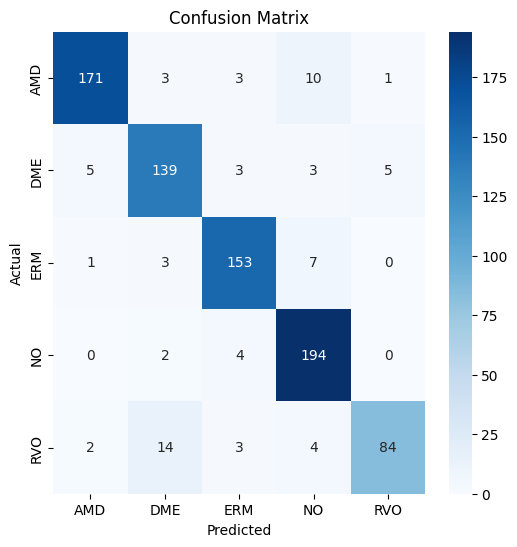

In [ ]:
# Final Evaluation on Test Set
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")

# Get Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\n📊 Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save('/content/model4.h5')


In [ ]:
#@title 5th model

In [ ]:
import os
import cv2
import numpy as np
import random
import shutil
from tqdm import tqdm
from google.colab import drive
import albumentations as A

In [ ]:
# Define paths
dataset_path = "/content/drive/MyDrive/graduation project/OCTDL"  # Path to the original dataset
output_path = "/content/drive/MyDrive/graduation project/trial"  # Path to save augmented data
split_path = os.path.join(output_path, "/content/drive/MyDrive/graduation project/trial_split")  # Path for dataset split

In [ ]:
# Define target classes
include_classes = ["AMD", "DME", "ERM", "NO"]  # Selected classes
augment_classes = ["DME", "ERM"]  # Classes for full augmentation
no_aug_classes = ["AMD"]  # Classes without augmentation
no_special_aug_classes = ["NO"]  # NO class gets specific augmentations


In [ ]:
# Create necessary directories
os.makedirs(output_path, exist_ok=True)
os.makedirs(split_path, exist_ok=True)


In [ ]:
#  Define augmentation functions
def mirror(img):
    return cv2.flip(img, 1)

def rotate(img, angle=15):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, matrix, (w, h))

def blur(img, ksize=(5, 5)):
    return cv2.GaussianBlur(img, ksize, 0)

def sharpen(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

#  Apply augmentation and save images
print("🔄 Applying data augmentation...")

for cls in include_classes:
    class_path = os.path.join(dataset_path, cls)
    save_path = os.path.join(output_path, cls)
    os.makedirs(save_path, exist_ok=True)

    images = os.listdir(class_path)

    for img_name in tqdm(images, desc=f"🔄 Processing {cls}"):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"⚠️ Warning: Skipping {img_name} (could not load)")
            continue

        # Save the original image
        cv2.imwrite(os.path.join(save_path, img_name), img)

        # 📌 **Augmentation for DME & ERM**
        if cls in augment_classes:
            #  Path 1: Mirror → Rotate → Blur & Sharpen
            mirrored = mirror(img)
            rotated_mirrored = rotate(mirrored)
            cv2.imwrite(os.path.join(save_path, f"mirrored_{img_name}"), mirrored)
            cv2.imwrite(os.path.join(save_path, f"rotated_mirrored_{img_name}"), rotated_mirrored)

            blur_img = blur(rotated_mirrored)
            sharpen_img = sharpen(rotated_mirrored)

            cv2.imwrite(os.path.join(save_path, f"blurred_mirrored_{img_name}"), blur_img)
            cv2.imwrite(os.path.join(save_path, f"sharpened_mirrored_{img_name}"), sharpen_img)

            # Path 2: Rotate → Blur & Sharpen
            rotated = rotate(img)
            cv2.imwrite(os.path.join(save_path, f"rotated_{img_name}"), rotated)

            blur_img2 = blur(rotated)
            sharpen_img2 = sharpen(rotated)

            cv2.imwrite(os.path.join(save_path, f"blurred_{img_name}"), blur_img2)
            cv2.imwrite(os.path.join(save_path, f"sharpened_{img_name}"), sharpen_img2)

        # **Augmentation for NO class**
        elif cls in no_special_aug_classes:
            mirrored = mirror(img)
            rotated_mirrored = rotate(mirrored)
            sharpened = sharpen(rotated_mirrored)

            cv2.imwrite(os.path.join(save_path, f"mirrored_{img_name}"), mirrored)
            cv2.imwrite(os.path.join(save_path, f"rotated_mirrored_{img_name}"), rotated_mirrored)
            cv2.imwrite(os.path.join(save_path, f"sharpened_{img_name}"), sharpened)

print(" Augmentation complete!")


🔄 Applying data augmentation...


🔄 Processing NO: 100%|██████████| 332/332 [00:36<00:00,  9.00it/s]

 Augmentation complete!


In [ ]:
# 🏷️ Split dataset into (train/val/test)
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

print("\n🔄 Splitting augmented dataset...")

# Create split directories
for split in ["train", "val", "test"]:
    for cls in include_classes:
        os.makedirs(os.path.join(split_path, split, cls), exist_ok=True)

for cls in include_classes:
    class_path = os.path.join(output_path, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    train_end = int(len(images) * train_ratio)
    val_end = train_end + int(len(images) * val_ratio)

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    # Move images to respective folders
    for img_name in train_imgs:
        shutil.move(os.path.join(class_path, img_name), os.path.join(split_path, "train", cls, img_name))

    for img_name in val_imgs:
        shutil.move(os.path.join(class_path, img_name), os.path.join(split_path, "val", cls, img_name))

    for img_name in test_imgs:
        shutil.move(os.path.join(class_path, img_name), os.path.join(split_path, "test", cls, img_name))

    # 🔍 Print class distribution
    print(f"\n✅ Split for {cls}:")
    print(f"   📂 Training: {len(train_imgs)} images")
    print(f"   📂 Validation: {len(val_imgs)} images")
    print(f"   📂 Testing: {len(test_imgs)} images")

print("\n Dataset splitting complete ✅")


🔄 Splitting augmented dataset...

✅ Split for AMD:
   📂 Training: 861 images
   📂 Validation: 184 images
   📂 Testing: 186 images

✅ Split for DME:
   📂 Training: 823 images
   📂 Validation: 176 images
   📂 Testing: 177 images

✅ Split for ERM:
   📂 Training: 868 images
   📂 Validation: 186 images
   📂 Testing: 186 images

✅ Split for NO:
   📂 Training: 929 images
   📂 Validation: 199 images
   📂 Testing: 200 images

 Dataset splitting complete ✅


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Paths to dataset directories
train_dir = "/content/drive/MyDrive/graduation project/trial_split/train"
val_dir = "/content/drive/MyDrive/graduation project/trial_split/val"
test_dir = "/content/drive/MyDrive/graduation project/trial_split/test"

In [ ]:
# Image properties
IMG_SIZE = (224, 224)  # VGG16 input size
BATCH_SIZE = 32

In [ ]:
# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

Found 3481 images belonging to 4 classes.
Found 745 images belonging to 4 classes.
Found 749 images belonging to 4 classes.


In [ ]:
# Load Pretrained VGG16 Model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add custom classification layers
x = Flatten()(base_model.output)  # Flatten the output of the base model
x = Dense(512, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.5)(x)  # Add dropout for regularization
output = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Output layer

In [ ]:
# Build Model
model = Model(inputs=base_model.input, outputs=output)  # Use the output tensor, not the layer

In [ ]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train Model with Validation Data
history = model.fit(
    train_generator,
    validation_data=val_generator,  # Using validation set during training
    epochs=10,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1207s 11s/step - accuracy: 0.5303 - loss: 1.1640 - val_accuracy: 0.8215 - val_loss: 0.4934
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 32s 290ms/step - accuracy: 0.8062 - loss: 0.5111 - val_accuracy: 0.8443 - val_loss: 0.4126
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 298ms/step - accuracy: 0.8721 - loss: 0.3701 - val_accuracy: 0.8617 - val_loss: 0.3339
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 32s 288ms/step - accuracy: 0.9030 - loss: 0.2847 - val_accuracy: 0.8886 - val_loss: 0.2962
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 32s 297ms/step - accuracy: 0.9141 - loss: 0.2564 - val_accuracy: 0.9060 - val_loss: 0.2482
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 32s 288ms/step - accuracy: 0.9307 - loss: 0.2064 - val_accuracy: 0.9007 - val_loss: 0.2407
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 301ms/step - accuracy: 0.9447 - loss: 0.1792 - val_accuracy: 0.9047 - val_loss: 0.2321
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 45s 337ms/step - accuracy: 0.9595 - loss: 0

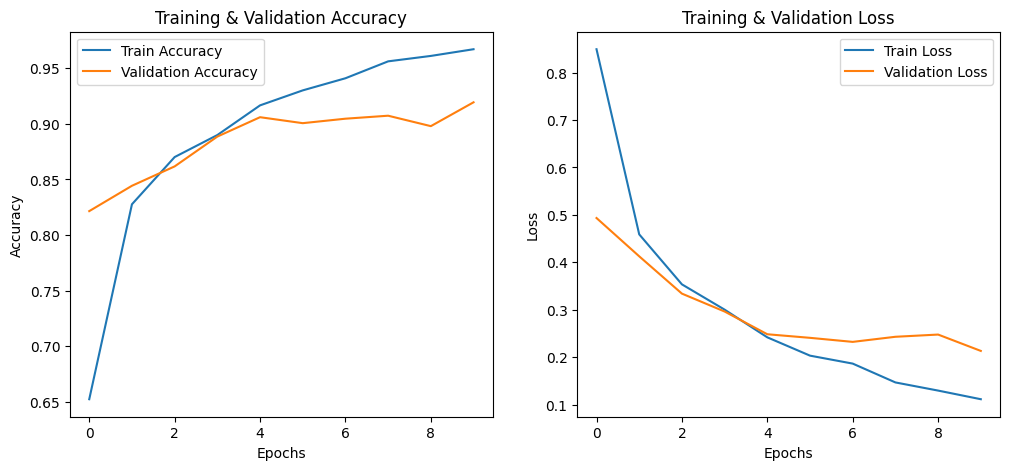

In [ ]:
# Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 238s 10s/step - accuracy: 0.9322 - loss: 0.2054
✅ Final Test Accuracy: 0.9226
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step

📊 Classification Report:
               precision    recall  f1-score   support

         AMD       0.94      0.95      0.95       186
         DME       0.99      0.87      0.92       177
         ERM       0.89      0.91      0.90       186
          NO       0.89      0.95      0.92       200

    accuracy                           0.92       749
   macro avg       0.93      0.92      0.92       749
weighted avg       0.93      0.92      0.92       749



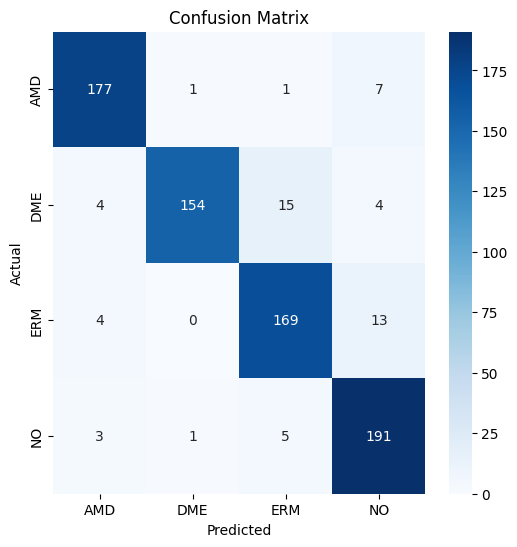


🔍 **Performance Metrics:**
✅ Classification Accuracy: 0.9226
📌 Sensitivity (Recall): 0.9213
📌 Specificity: 0.9740
📌 Precision: 0.9266
📌 False Positive Rate (FPR): 0.0260
📌 False Negative Rate (FNR): 0.0787
📌 Negative Predictive Value (NPV): 0.9745
📌 F1 Score: 0.9227


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

# ✅ Final Evaluation on Test Set
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")

# Get Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 📊 Classification Report
print("\n📊 Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

# 📌 Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 🎯 Calculate Performance Metrics
TP = np.diag(conf_matrix)  # True Positives
FP = np.sum(conf_matrix, axis=0) - TP  # False Positives
FN = np.sum(conf_matrix, axis=1) - TP  # False Negatives
TN = np.sum(conf_matrix) - (TP + FP + FN)  # True Negatives

# 🔹 Classification Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# 🔹 Sensitivity (Recall)
sensitivity = recall_score(y_true, y_pred_classes, average='macro')

# 🔹 Specificity
specificity = np.mean(TN / (TN + FP))

# 🔹 Precision
precision = precision_score(y_true, y_pred_classes, average='macro')

# 🔹 False Positive Rate (FPR)
fpr = np.mean(FP / (FP + TN))

# 🔹 False Negative Rate (FNR)
fnr = np.mean(FN / (TP + FN))

# 🔹 Negative Predictive Value (NPV)
npv = np.mean(TN / (TN + FN))

# 🔹 F1 Score
f1 = f1_score(y_true, y_pred_classes, average='macro')

# 📝 Print Metrics
print(f"\n🔍 **Performance Metrics:**")
print(f"✅ Classification Accuracy: {accuracy:.4f}")
print(f"📌 Sensitivity (Recall): {sensitivity:.4f}")
print(f"📌 Specificity: {specificity:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 False Positive Rate (FPR): {fpr:.4f}")
print(f"📌 False Negative Rate (FNR): {fnr:.4f}")
print(f"📌 Negative Predictive Value (NPV): {npv:.4f}")
print(f"📌 F1 Score: {f1:.4f}")


In [ ]:
model.save('/content/model0.h5')

In [ ]:
**Per-Class Performance Metrics:** model 1

🔹 **Class AMD:**
    Sensitivity (Recall): 0.9377
    Specificity: 0.8418
    Precision: 0.8972
    False Positive Rate (FPR): 0.1582
    False Negative Rate (FNR): 0.0623
    Negative Predictive Value (NPV): 0.9017
    F1 Score: 0.917

🔹 **Class DME:**
    Sensitivity (Recall): 0.3835
    Specificity: 0.9954
    Precision: 0.8644
    False Positive Rate (FPR): 0.0046
    False Negative Rate (FNR): 0.6165
    Negative Predictive Value (NPV): 0.9545
    F1 Score: 0.5312

🔹 **Class ERM:**
    Sensitivity (Recall): 0.6214
    Specificity: 0.9779
    Precision: 0.696
    False Positive Rate (FPR): 0.0221
    False Negative Rate (FNR): 0.3786
    Negative Predictive Value (NPV): 0.9695
    F1 Score: 0.6566

🔹 **Class NO:**
    Sensitivity (Recall): 0.9398
    Specificity: 0.9391
    Precision: 0.7473
    False Positive Rate (FPR): 0.0609
    False Negative Rate (FNR): 0.0602
    Negative Predictive Value (NPV): 0.9879
    F1 Score: 0.8326

🔹 **Class RAO:**
    Sensitivity (Recall): 0.0
    Specificity: 1.0
    Precision: 0
    False Positive Rate (FPR): 0.0
    False Negative Rate (FNR): 1.0
    Negative Predictive Value (NPV): 0.9892
    F1 Score: 0

🔹 **Class RVO:**
    Sensitivity (Recall): 0.6813
    Specificity: 0.9791
    Precision: 0.6263
    False Positive Rate (FPR): 0.0209
    False Negative Rate (FNR): 0.3187
    Negative Predictive Value (NPV): 0.9835
    F1 Score: 0.6526

🔹 **Class VID:**
    Sensitivity (Recall): 0.5652
    Specificity: 0.9978
    Precision: 0.907
    False Positive Rate (FPR): 0.0022
    False Negative Rate (FNR): 0.4348
    Negative Predictive Value (NPV): 0.9835
    F1 Score: 0.6964